In [1]:
import modelutils
import utils
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras import callbacks
import pprint
import glob
import pickle

Using TensorFlow backend.


# Finding the latest dataset-paths.

In [2]:
dataset_name_voxelgrid = sorted([x for x in glob.glob("*.p") if "voxelgrid-dataset" in x])[-1]
print(dataset_name_voxelgrid)

dataset_name_pointcloud = sorted([x for x in glob.glob("*.p") if "pointcloud-dataset" in x])[-1]
print(dataset_name_pointcloud)

20180731-1325-voxelgrid-dataset.p
20180731-1245-pointcloud-dataset.p


# Miscellaneous stuff.

In [3]:
pp = pprint.PrettyPrinter(indent=4)

In [4]:
tensorboard_callback = callbacks.TensorBoard()
histories = []

In [5]:
def save_model_and_history(model, history, name):
    
    print("Saving model and history...")
    
    datetime_string = utils.get_datetime_string()
    
    model_name = datetime_string + "-" + name + "-model.h5"
    model_voxnet.save(model_name)
    print("Saved model to" + model_name)

    
    history_name = datetime_string + "-" + name + "-history.p"
    pickle.dump(history.history, open(history_name, "wb"))
    print("Saved history to" + history_name)

# Training VoxNet.

In [6]:
dataset_name = dataset_name_voxelgrid

print("Loading dataset...")
(x_input_train, y_output_train), (x_input_test, y_output_test), dataset_parameters = pickle.load(open(dataset_name, "rb"))
pp.pprint(dataset_parameters)

Loading dataset...
{   'dataset_size_test': 1000,
    'dataset_size_train': 6000,
    'input_type': 'voxelgrid',
    'output_targets': ['height', 'weight'],
    'random_seed': 666,
    'voxel_size_meters': 0.1,
    'voxelgrid_random_rotation': True,
    'voxelgrid_target_shape': (32, 32, 32)}


In [7]:
input_shape = (32, 32, 32)
output_size = 2 
model_voxnet = modelutils.create_voxnet_model_homepage(input_shape, output_size)
model_voxnet.summary()

 # Compile the model.
model_voxnet.compile(
        optimizer="rmsprop",
        loss="mse",
        metrics=["mae"]
    )

# Train the model.
history = model_voxnet.fit(
    x_input_train, y_output_train,
    epochs=50,
    validation_data=(x_input_test, y_output_test),
    callbacks=[tensorboard_callback]
    )

histories.append(history)

save_model_and_history(model_voxnet, history, "voxnet")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 32, 32, 32, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 14, 14, 14, 32)    4032      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 12, 12, 12, 32)    27680     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 6, 6, 32)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6912)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               884864    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total para

# Training PointNet.

In [8]:
dataset_name = dataset_name_pointcloud

print("Loading dataset...")
(x_input_train, y_output_train), (x_input_test, y_output_test), dataset_parameters = pickle.load(open(dataset_name, "rb"))
pp.pprint(dataset_parameters)

def transform(x_input, y_output):

    x_input_transformed = []
    y_output_transformed = []
    for input_sample, output_sample in zip(x_input_train, y_output_train):
        if input_sample.shape[0] == 30000:
            x_input_transformed.append(input_sample[:,0:3])
            y_output_transformed.append(output_sample)
        else:
            # TODO maybe do some padding here?
            print("Ignoring shape:", input_sample.shape)
            
    x_input_transformed = np.array(x_input_transformed)
    y_output_transformed = np.array(y_output_transformed)
    return x_input_transformed, y_output_transformed
    
x_input_train, y_output_train = transform(x_input_train, y_output_train)
x_input_test, y_output_test = transform(x_input_test, y_output_test)

print("Training data input shape:", x_input_train.shape)
print("Training data output shape:", y_output_train.shape)
print("Testing data input shape:", x_input_test.shape)
print("Testing data output shape:", y_output_test.shape)
print("")

Loading dataset...
{   'dataset_size_test': 500,
    'dataset_size_train': 3000,
    'input_type': 'pointcloud',
    'output_targets': ['height', 'weight'],
    'pointcloud_random_rotation': True,
    'pointcloud_target_size': 30000,
    'random_seed': 666}
Ignoring shape: (27205, 4)
Ignoring shape: (29891, 4)
Ignoring shape: (26896, 4)
Ignoring shape: (27134, 4)
Ignoring shape: (29011, 4)
Ignoring shape: (28040, 4)
Ignoring shape: (26228, 4)
Ignoring shape: (26965, 4)
Ignoring shape: (26611, 4)
Ignoring shape: (25740, 4)
Ignoring shape: (27451, 4)
Ignoring shape: (26563, 4)
Ignoring shape: (26166, 4)
Ignoring shape: (27564, 4)
Ignoring shape: (27773, 4)
Ignoring shape: (27134, 4)
Ignoring shape: (27807, 4)
Ignoring shape: (27089, 4)
Ignoring shape: (27773, 4)
Ignoring shape: (27709, 4)
Ignoring shape: (25900, 4)
Ignoring shape: (27288, 4)
Ignoring shape: (27807, 4)
Ignoring shape: (29601, 4)
Ignoring shape: (26742, 4)
Ignoring shape: (26304, 4)
Ignoring shape: (26793, 4)
Ignoring shap

In [9]:
input_shape = (30000, 3)
output_size = 2 
model_pointnet = modelutils.create_point_net(input_shape, output_size)
model_pointnet.summary()

 # Compile the model.
model_pointnet.compile(
        optimizer="rmsprop",
        loss="mse",
        metrics=["mae"]
    )

# Train the model.
history = model_pointnet.fit(
    x_input_train, y_output_train,
    epochs=50,
    validation_data=(x_input_test, y_output_test),
    callbacks=[tensorboard_callback],
    batch_size=8
    )

histories.append(history)

save_model_and_history(model_voxnet, history, "pointnet")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30000, 3)          0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 30000, 3)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 30000, 64)         256       
_________________________________________________________________
batch_normalization_6 (Batch (None, 30000, 64)         256       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 30000, 64)         4160      
_________________________________________________________________
batch_normalization_7 (Batch (None, 30000, 64)         256       
_________________________________________________________________
lambda_2 (Lambda)            (None, 30000, 64)         0         
__________

# Plot the histories.

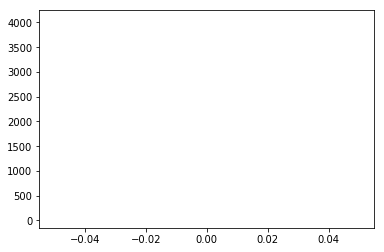

In [14]:
def plot_histories(histories, names):
    for index, (history, name) in enumerate(zip(histories, names)):
        for key, data in history.history.items():
            plt.plot(data, label=name + "-" + key)
    
    # TODO consider: plt.savefig()
    plt.show()
    plt.close()
    
plot_histories(histories, ["voxnet", "pointnet"])